# Minimum distance, number of stations and area coverage.

TO DO: nyc, remove staten island
TO DO: add colorbars
TO DO: save figures

In [780]:
import geopandas
import geoplot
import numpy as np
import pandas as pd
import random
import geojson
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import plotly.express as px
import tqdm
import seaborn as sns
import matplotlib as mpl
import geoplot.crs as gcrs
from bs4 import BeautifulSoup
import requests

In [778]:
# define functions
# matplotlib params 
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"   
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

# matplotlib adjustments
def default_plot(ax, spines): 
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax


# get exterior of multipolygon
def get_exterior(geo_col):
    union = geo_col.unary_union
    return union

# generate random points within polygon
def random_points_within(poly, num_points):
  
    # get exterior limits of the polygon
    min_x, min_y, max_x, max_y = poly.bounds

    points = []
    
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        # if point inside polygon
        if (random_point.within(poly)):
            points.append(random_point)

    return points

# parse URL
def response_and_soup(url):
    
    """
    Turns links into soup.
    Input: URL to scrape
    Output: the soup from BeautifulSoup package
    """
    
    # get response
    response = requests.get(url)
    print('Response code:', response.status_code)
    
    # cook soup
    soup = BeautifulSoup(response.content, "html.parser")
    
    return soup


In [823]:
# takes in as input a boundary area and points of interest (lat/lon)
# THE REGION MUST HAVE A GEOMETRY COLUMN!
# POINTS OF INTEREST MUST BE IN SHAPELY POINT COORDINATES: POINT (LAT LON)

def min_distance_random(region, poi, npoints):
    
    # union between polygons
    exterior = get_exterior(region)
    
    # remove points outside the city
    poi = [point for point in poi if point.within(exterior)]
           
    # plot figure to see input data
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    for p in poi:  
        ax.scatter(p.x, p.y, facecolor='r', edgecolor='k', s=50);
    ax.set_title('Area Boundary and Points of Interest')
    
    # random point generation within the boundary area
    random_points = random_points_within(exterior, npoints)
    
    # showing random points generated
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    for rp in random_points:  
        ax.scatter(rp.x, rp.y, facecolor='r', edgecolor=None, s=1);
    ax.set_title('Random Points Generated')
    
    # calculate distances from random point to every point of interest and grab the minimum
    distances = []
    for rp in random_points: 
        # multiply by 100000 (scale)
        distances += [min([rp.distance(p) for p in poi]) * 100000]
        
    # distance histogram    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax = default_plot(ax, ['left'])
    plt.xlabel('Distance to closest POI (m)')
    plt.ylabel('Number of points')
    plt.hist(distances, bins=50, color='k', rwidth=.85);
        
    # plot final data
    # extract x and y coordinates to plot with heatmap
    x_coords = [p.x for p in random_points]
    y_coords = [p.y for p in random_points]

    plt.figure()
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    ax.scatter(x_coords, y_coords, c=distances, cmap='viridis_r', edgecolor=None, s=10);
    ax.set_title('Distance to Closest Point of Interest')
    
    # this kind of measures number of options rather than availability of 1 option.
    # Calculate number of stations within 1 km.
    circles = geopandas.GeoSeries(random_points).buffer(0.01)
    
    n_inside = []
    for circle in circles:
        count = 0
        for p in poi:
            if p.within(circle):
                count += 1
        n_inside += [count]
        
    # plot histogram
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = default_plot(ax, ['left'])
    plt.xlabel('Probability')
    plt.ylabel('Number of points')
    plt.title('Probability of X Points (within 1km)')
    plt.hist(n_inside, bins= max(n_inside), color='k', rwidth=.9, density= True);
        
    # plot map
    plt.figure()
    ax = geoplot.polyplot(region, figsize=(10, 10), lw= 1, facecolor= 'none', edgecolor='k', alpha=1);
    ax.scatter(x_coords, y_coords, c=n_inside, cmap='viridis', edgecolor=None, s=5);
    ax.set_title('Number of Stations (within 1km)')
        
    # next one up is percentage of area covered
    # we draw circles of defined radius around each of our points of interest
    poi_area = geopandas.GeoSeries(poi).buffer(0.01).unary_union
    intersection = region['geometry'].difference(poi_area)
    
    # calculate proportion of area covered
    area_covered = poi_area.area/region.geometry.unary_union.area
    
    # plot intersection area
    ax = geoplot.polyplot(intersection[~intersection.is_empty], figsize=(10, 10), lw= 1, color='grey', alpha=0.7);    
    for p in poi:  
        ax.scatter(p.x, p.y, facecolor='r', edgecolor='k', s=50);
    
    return distances, n_inside, area_covered, random_points

# Lisbon

In [755]:
# open data files
lisbon = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/lisbon/lisbon.shp').to_crs(epsg=4326)
metro_raw = pd.read_json('C:/Users/Zaca/Documents/Datasets/metro/lisbon/lisbon_subway.geojson')
metro = json_normalize(metro_raw['features'])

# save coordinates
lisbon_stations = metro['geometry.coordinates']
lisbon_stations = [Point(x, y) for x, y in lisbon_stations]

In [756]:
# clean metro data
metro['properties.INF_DESCRICAO'].fillna('vermelha', inplace= True)

clean_lines = []

for s in metro['properties.INF_DESCRICAO']:
    
    line = s.lower().replace('\n', '').replace('linha', '').replace(';', '/').replace('.', '/').strip().split('/')
    
    if len(line) > 2:
        line = [line[0]]
    else:
        line = [line.strip() for line in line]
        
    clean_lines += [line]

metro['properties.INF_DESCRICAO'] = clean_lines

In [721]:
# verification of distances with google maps
restauradores = [Point(x, y) for x, y in metro[metro['properties.INF_NOME'] == 'Restauradores']['geometry.coordinates']]
saldanha = [Point(x, y) for x, y in metro[metro['properties.INF_NOME'] == 'Saldanha']['geometry.coordinates']]
google_measured = 2260
print(restauradores[0].distance(saldanha[0])*100000)

1941.22559344421


## Lisbon Data Ready

C:\Users\Zaca\Anaconda3\lib\site-packages\descartes\patch.py:87: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



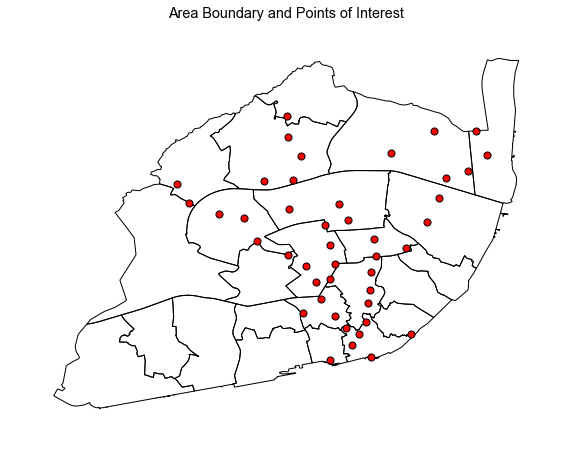

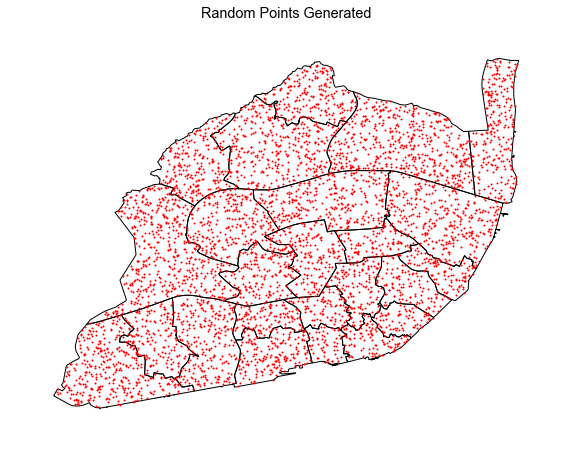

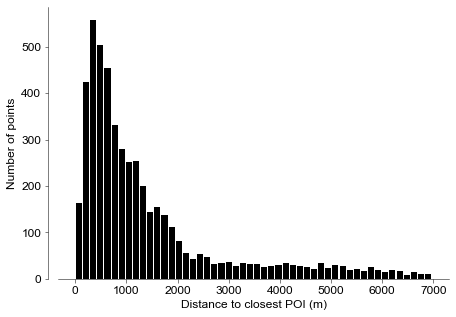

<Figure size 432x288 with 0 Axes>

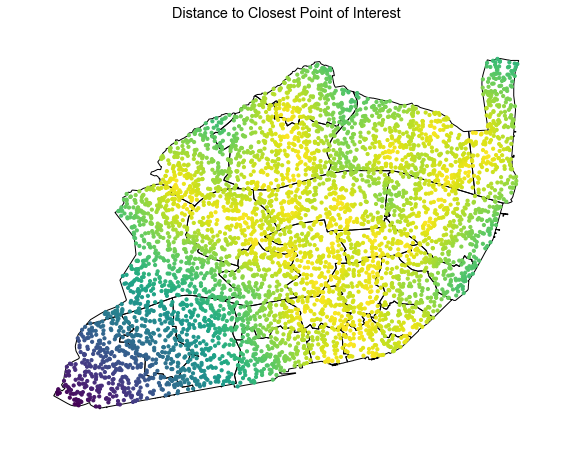

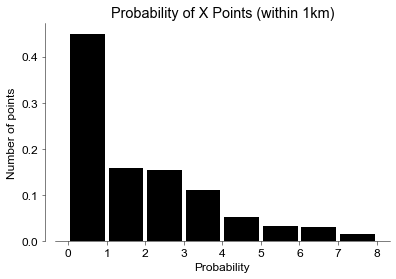

<Figure size 432x288 with 0 Axes>

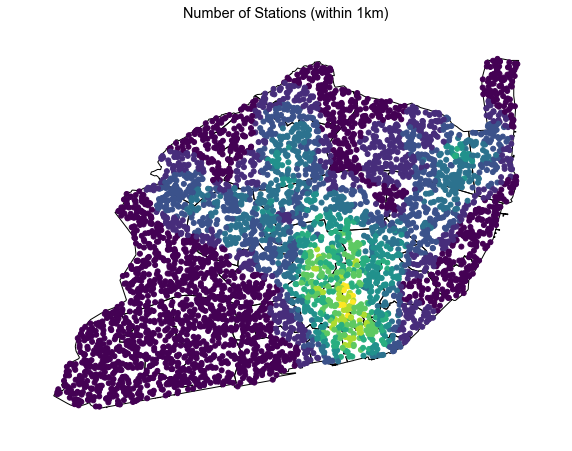

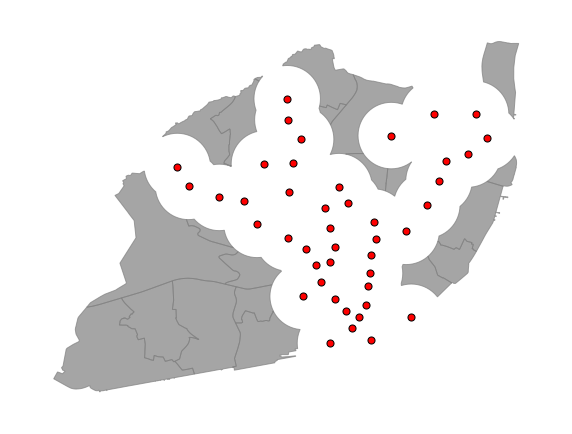

In [772]:
lisbon_distances, lisbon_n_points, lisbon_area_covered, lisbon_random = min_distance_random(lisbon, lisbon_stations, 5000)

# New York City

In [817]:
# open data files
nyc = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/nyc/nyc.shp').to_crs(epsg=4326)
nyc_metro = pd.read_csv('C:/Users/Zaca/Documents/Datasets/metro/nyc/nyc_subway.csv')

In [818]:
nyc_stations = nyc_metro['the_geom'].str.replace('POINT ', '').str.replace('(', '').str.replace(')', '').str.split(' ')

In [819]:
# unfortunately this comes in string jesus christ.
nyc_stations_float = []
    
for i in range(len(nyc_stations)):
    nyc_stations_float += [[float(x) for x in nyc_stations[i]]]

nyc_stations = [Point(x, y) for x, y in nyc_stations_float]

### NYC Data Ready

C:\Users\Zaca\Anaconda3\lib\site-packages\descartes\patch.py:87: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



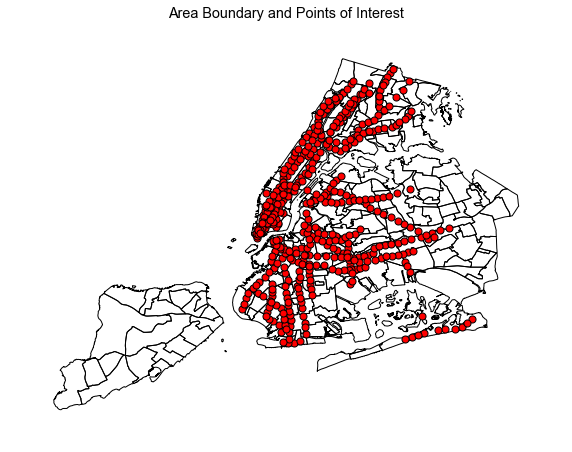

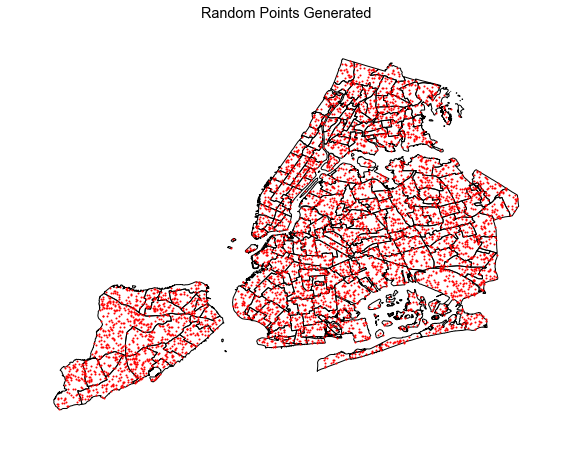

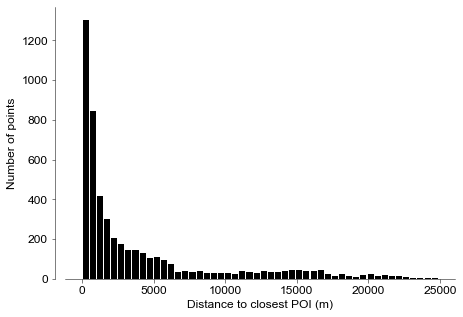

<Figure size 432x288 with 0 Axes>

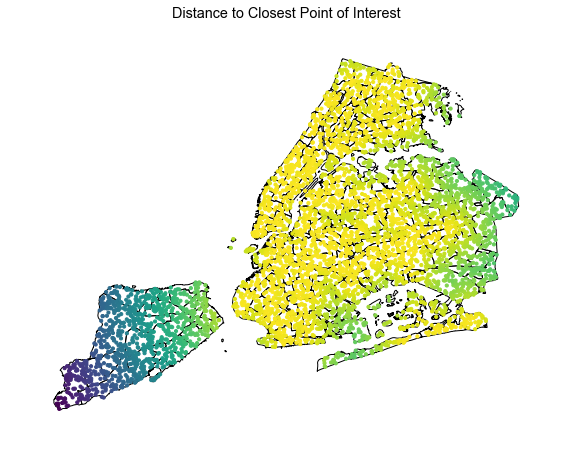

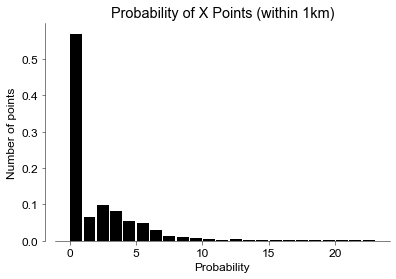

<Figure size 432x288 with 0 Axes>

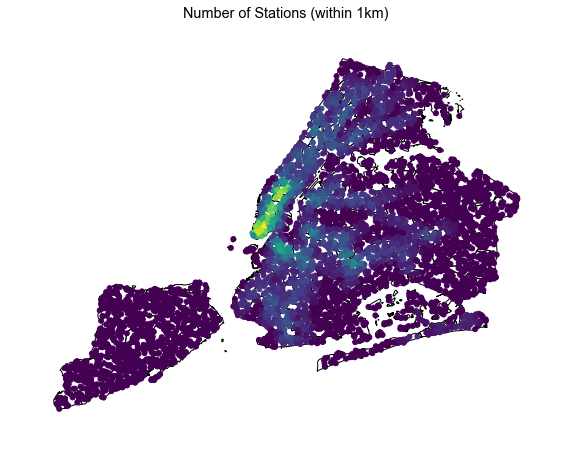

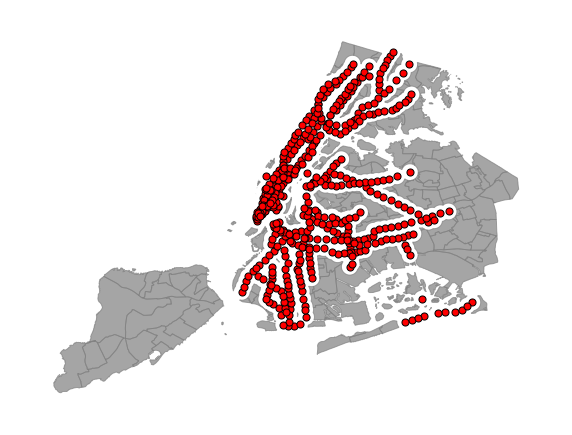

In [820]:
#nyc_distances, nyc_n_points, nyc_area_covered, nyc_random = min_distance_random(nyc, nyc_stations, 5000)

### NYC Correlation with Population Density

In [822]:
nyc['nstations'] = 

0      497498.701
1      589296.926
2      1506628.84
3      468975.876
4      125384.135
          ...    
190     477391.96
191     703387.79
192    340431.235
193    211994.513
194    1230989.52
Name: popdty, Length: 195, dtype: object

# Paris

In [743]:
paris = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/paris/paris.shp').to_crs(epsg=4326)

# clean metro data
metro_raw = pd.read_json('C:/Users/Zaca/Documents/Datasets/metro/paris/paris_subway.geojson')
metro = json_normalize(metro_raw['features'])

paris_stations = metro.loc[metro['geometry.type'] == 'MultiPoint', 'geometry.coordinates']
paris_stations = [x[0] for x in paris_stations]
paris_stations = [Point(x, y) for x, y in paris_stations]

C:\Users\Zaca\Anaconda3\lib\site-packages\descartes\patch.py:87: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



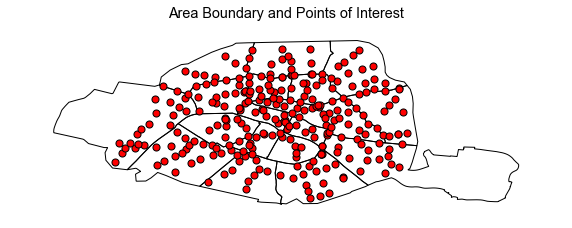

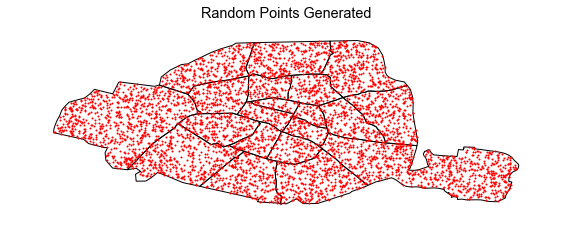

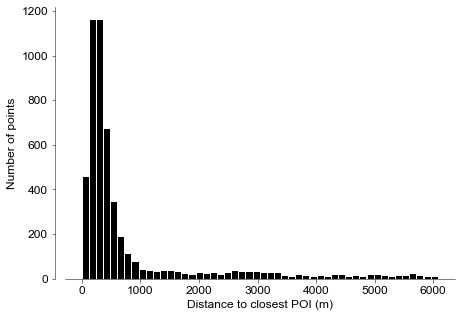

<Figure size 432x288 with 0 Axes>

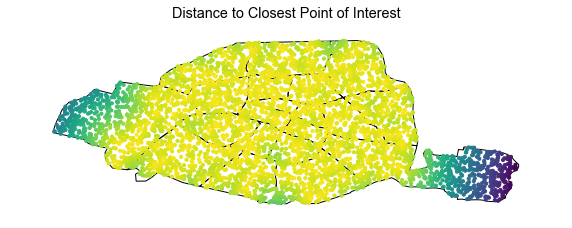

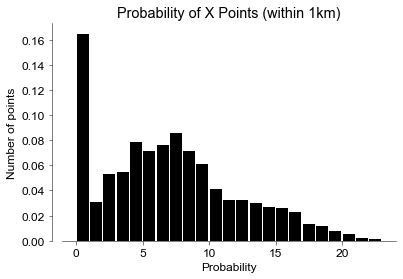

<Figure size 432x288 with 0 Axes>

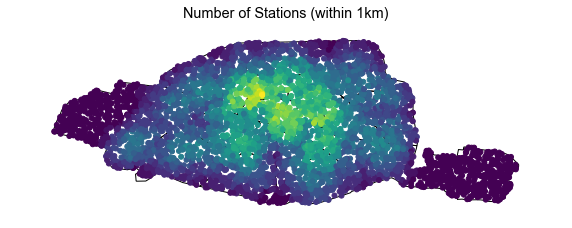

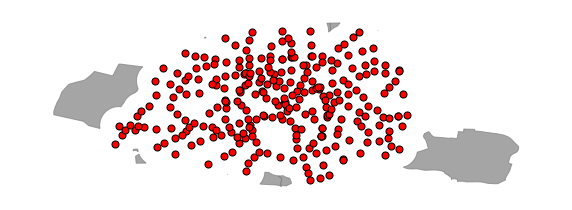

In [773]:
paris_distances, paris_n_points, paris_area_covered, paris_random = min_distance_random(paris, paris_stations, 5000)

# Moscow

In [788]:
# get map
moscow = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/moscow/moscow.shp').to_crs(epsg=4326)
moscow = moscow[moscow['NAME_1'] == 'Moscow City']

# scrape locations from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
soup = response_and_soup(url)

location_text = [t.text for t in soup.find_all('span', {'class':'geo-dec'})]

location_text = [s.replace('°', '').replace('N', '').replace('E', '').split(' ') for s in location_text]

latlong = []
for s in location_text:
    latlong += [[float(x) for x in s]]
    
moscow_stations = [Point(x, y) for y, x in latlong]

Response code: 200


### Moscow Data Ready

C:\Users\Zaca\Anaconda3\lib\site-packages\descartes\patch.py:87: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



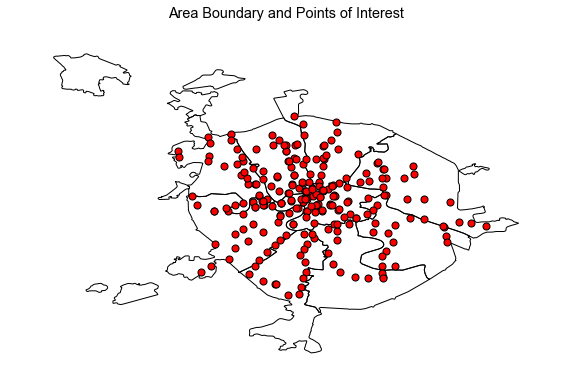

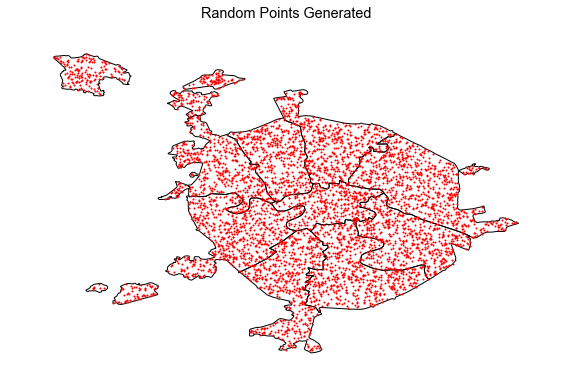

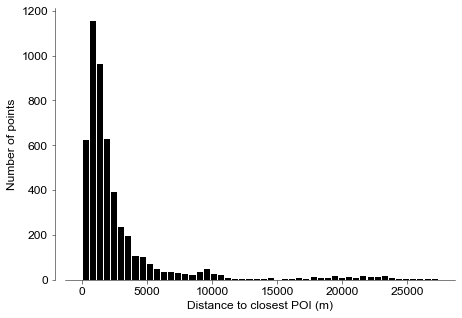

<Figure size 432x288 with 0 Axes>

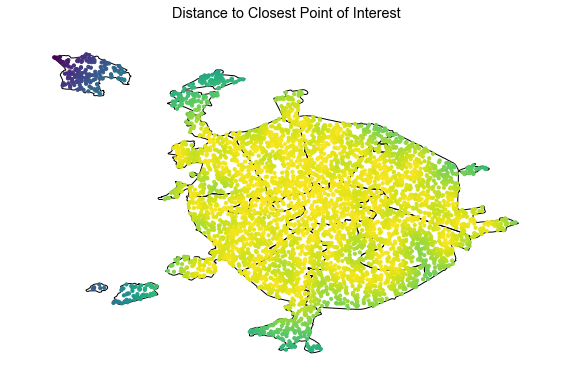

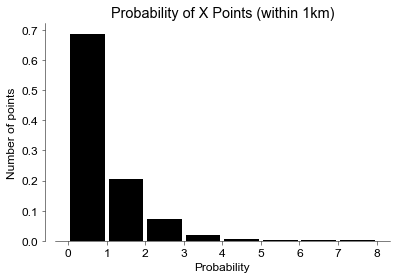

<Figure size 432x288 with 0 Axes>

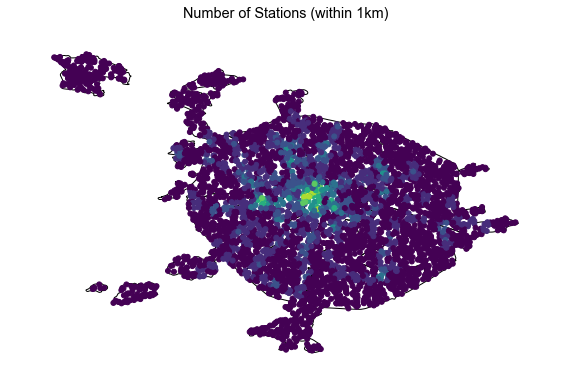

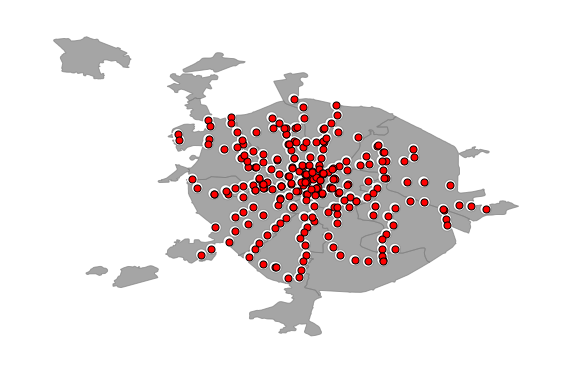

In [791]:
moscow_distances, moscow_n_points, moscow_area_covered, moscow_random = min_distance_random(moscow, moscow_stations, 5000)

# London

In [805]:
# opening london geometry
london = geopandas.read_file('C:/Users/Zaca/Documents/Datasets/metro/london/london.shp').to_crs(epsg=4326)
london = london[london['Designated'] == 'Inner']

# opening underground station location
london_location = 'C:/Users/Zaca/Documents/Datasets/metro/london/stations.kml'

with open(london_location) as f:
    soup = BeautifulSoup(f, 'xml')
    
coordinates = [t.text for t in soup.find_all('coordinates')]

stations = [s.replace('\n', '').replace('\t', '').replace(',0', '').split(',') for s in coordinates]

station_float = []
for station in stations:
    station_float += [[float(x) for x in station]]
    
london_stations = [Point(x, y) for x, y in station_float]

### London Data Ready

C:\Users\Zaca\Anaconda3\lib\site-packages\descartes\patch.py:87: UserWarning:

Setting the 'color' property will override the edgecolor or facecolor properties.



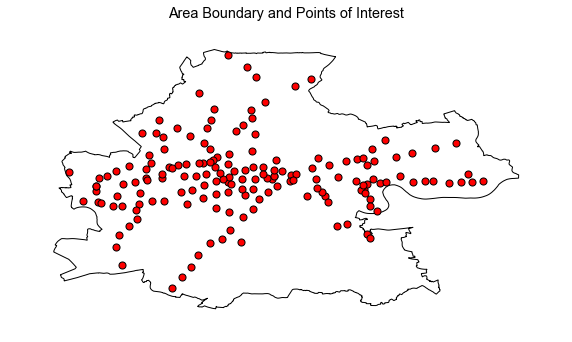

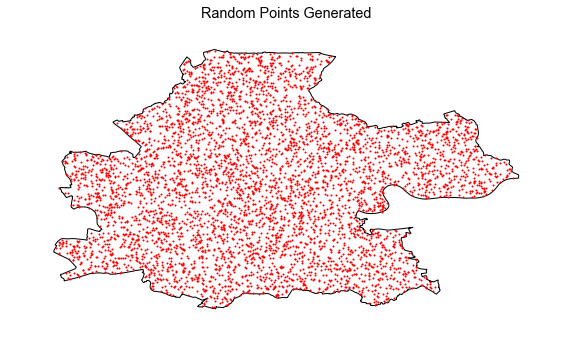

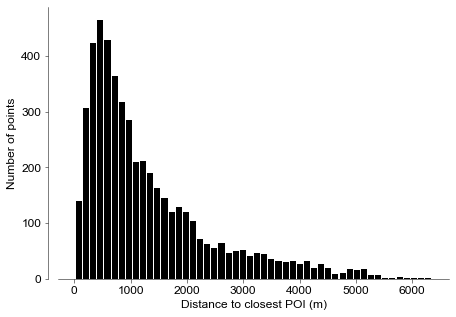

<Figure size 432x288 with 0 Axes>

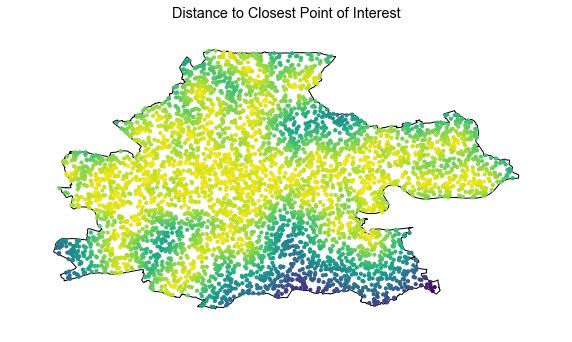

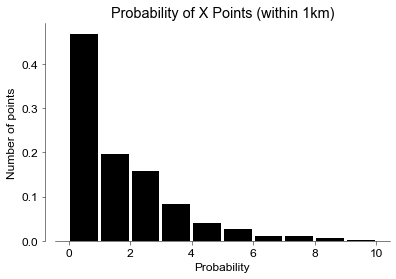

<Figure size 432x288 with 0 Axes>

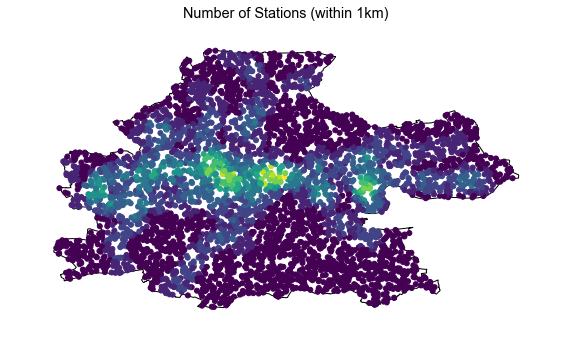

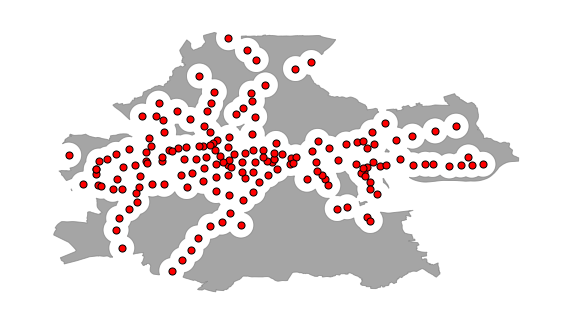

In [806]:
london_distances, london_n_points, london_area_covered, london_random = min_distance_random(london, london_stations, 5000)